In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Conv2D, Flatten, Add, Cropping2D, Layer
from tensorflow.keras.layers import UpSampling2D, Reshape, AveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softplus as f
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
#from tensorflow.keras.datasets import mnist
from keras.utils import Progbar

from skimage.transform import resize
from skimage import io

Using TensorFlow backend.


This is an implementation of the StyleALAE which has a symmetrical encoder and decoder, using Instance Normalisation and Adaptive Instance Normalisation introduced [here](https://arxiv.org/pdf/1703.06868.pdf). IN is available as part of `tfa` and `AdaIn` is a custom layer.

In [2]:
# --- SET SEED --- #
np.random.seed(0)
# ---------------- #

In [3]:
normal = tf.initializers.RandomNormal

class DenseEQ(Dense):
    """
    Standard dense layer but includes learning rate equilization
    at runtime as per Karras et al. 2017.

    Inherits Dense layer and overides the call method.
    """
    def __init__(self, **kwargs):
        if 'kernel_initializer' in kwargs:
            raise Exception("Cannot override kernel_initializer")
        super().__init__(kernel_initializer=normal(0, 1), **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # The number of inputs
        n = np.product([int(val) for val in input_shape[1:]])
        # He initialisation constant
        self.c = np.sqrt(2/n)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel*self.c) # scale kernel
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [4]:
class Conv2DEQ(Conv2D):
    """
    Standard Conv2D layer but includes learning rate equilization
    at runtime as per Karras et al. 2017.

    Inherits Conv2D layer and overrides the call method, following
    https://github.com/keras-team/keras/blob/master/keras/layers/convolutional.py
    
    """
    def __init__(self, **kwargs):
        if 'kernel_initializer' in kwargs:
            raise Exception("Cannot override kernel_initializer")
        super().__init__(kernel_initializer=normal(0, 1), **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # The number of inputs
        n = np.product([int(val) for val in input_shape[1:]])
        # He initialisation constant
        self.c = np.sqrt(2/n)

    def call(self, inputs):
        if self.rank == 2:
            outputs = K.conv2d(
                inputs,
                self.kernel*self.c, # scale kernel
                strides=self.strides,
                padding=self.padding,
                data_format=self.data_format,
                dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

In [5]:
# weighted sum output
class WeightedSum(Add):
    # init with default value
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = K.variable(alpha, name='ws_alpha')

    # output a weighted sum of inputs
    def _merge_function(self, inputs):
        # only supports a weighted sum of two inputs
        assert (len(inputs) == 2)
        # ((1-a) * input1) + (a * input2)
        output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
        return output

In [6]:
class AdaInstanceNormalization(Layer):
    """
    This is the AdaInstanceNormalization layer used by
    
    manicman199 available at https://github.com/manicman1999/StyleGAN-Keras
    
    """
    def __init__(self, 
             axis=-1,
             momentum=0.99,
             epsilon=1e-3,
             center=True,
             scale=True,
             **kwargs):
        super(AdaInstanceNormalization, self).__init__(**kwargs)
        self.axis = axis
        self.momentum = momentum
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
    
    
    def build(self, input_shape):
    
        dim = input_shape[0][self.axis]
        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape[0]) + '.')
    
        super(AdaInstanceNormalization, self).build(input_shape) 
    
    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs[0])
        reduction_axes = list(range(0, len(input_shape)))
        
        beta = inputs[1]
        gamma = inputs[2]

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]
        mean = K.mean(inputs[0], reduction_axes, keepdims=True)
        stddev = K.std(inputs[0], reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs[0] - mean) / stddev

        return normed * gamma + beta
    
    def get_config(self):
        config = {
            'axis': self.axis,
            'momentum': self.momentum,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale
        }
        base_config = super(AdaInstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [7]:
class MeanAndStDev(Layer):
    """
    This is the Instance Normalization transformation which
    concatentates mu and sigma to latter be mapped to w.
    """
    def __init__(self,**kwargs):
        super(MeanAndStDev, self).__init__(**kwargs)

    def build(self, input_shape):
        super(MeanAndStDev, self).build(input_shape) 
    
    def call(self, inputs):
        m = K.mean(inputs, axis=[1, 2], keepdims=True)
        std = K.std(inputs, axis=[1, 2], keepdims=True)
        statistics = K.concatenate([m, std], axis=1)
        return statistics

Given the complexity of growing the encoder, it is better to create the encoder EncoderBlock as a Model.

In [8]:
class EncoderBlock(Model):
    """
    Encoder block using instance normalisation to extract style.
    """
    def __init__(self, filters, block, z_dim, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # Attributes
        self.filters = filters
        self.block = block
        self.z_dim = z_dim
        dim =  2**(block+1)

        # Trainable Layers
        self.conv1 = Conv2DEQ(filters=filters, kernel_size=(3, 3), padding="same", name=f"E_block_{block}_Conv_1")
        self.act1 = LeakyReLU(0.2, name=f"E_block_{block}_Act_1")
        self.msd = MeanAndStDev(name=f"E_block_{block}_msd")
        self.in1 = InstanceNormalization(name=f"E_block_{block}_IN_1", center=False, scale=False)
        self.in2 = InstanceNormalization(name=f"E_block_{block}_IN_2", center=False, scale=False)
        self.conv2 = Conv2DEQ(filters=filters, kernel_size=(3, 3), padding="same", name=f"E_block_{block}_Conv_2")
        self.act2 = LeakyReLU(0.2, name=f"E_block_{block}_Act_2")
        self.downsample = AveragePooling2D(name=f"E_block_{block}_DownSample")
        self.mapStyle1 = DenseEQ(units=z_dim, name=f"E_block_{block}_style_1")
        self.mapStyle2 = DenseEQ(units=z_dim, name=f"E_block_{block}_style_2")
        self.flatten = Flatten(name=f"E_block_{block}_flatten")
          
    def call(self, inputs):
        # Convolution 1
        x = self.conv1(inputs)
        x = self.act1(x)
        
        # Instance Normalisation 1
        style1 = self.flatten(self.msd(x))
        x = self.in1(x)
        
        # Convolution 2
        x = self.conv2(x)
        if self.block > 1:
            x = self.downsample(x)
        x = self.act2(x)
        
        # Instance Normalisation 2
        style2 = self.flatten(self.msd(x))
        x = self.in2(x)
        
        # Affine transform to style vectors
        w1 = self.mapStyle1(style1)
        w2 = self.mapStyle2(style2)
        
        return x, w1, w2

In [9]:
def CropNoise(noise_tensor, size, block):
    """
    Crops the noise_tensor to the target size.
    """
    cut = (noise_tensor.shape[1]-size)//2
    crop = Cropping2D(cut, name=f"G_Noise_Crop_block_{block}")(noise_tensor)
    return crop

Similarly, building the GeneratorBlock as a Model makes progressive growing possible.

In [10]:
class GeneratorBlock(Model):
    """
    Generator block using adaptive instance normalisation to inject style.
    """
    def __init__(self, filters, block, **kwargs):
        super(GeneratorBlock, self).__init__(**kwargs)
        # Attributes
        self.filters = filters
        self.block = block
        self.dim =  2**(block+1)

        # Trainable Layers
        
        # phase 1
        self.upsample =  UpSampling2D(name=f"G_block_{block}_UpSample")
        self.beta1 = DenseEQ(units=filters, name=f"G_block_{block}_beta1")
        self.beta1r = Reshape([1, 1, filters], name=f"G_block_{block}_beta1_reshape")
        self.gamma1 = DenseEQ(units=filters, name=f"G_block_{block}_gamma1")
        self.gamma1r = Reshape([1, 1, filters], name=f"G_block_{block}_gamma1_reshape")
        self.noise1 = Conv2DEQ(filters=filters, kernel_size=1, padding='same', name=f"G_block_{block}_noise_bias1")
        self.conv1 = Conv2DEQ(filters=filters, kernel_size=3, padding='same', name=f"G_block_{block}_decoder_conv1")
        self.AdaIn1 = AdaInstanceNormalization(name=f"G_block_{block}_AdaIN_1")
        self.addNoise1 = Add(name=f"G_block_{block}_Add_1")
        self.act1 = LeakyReLU(0.2, name=f"G_block_{block}_Act_1")
            
        # phase 2
        self.beta2 = DenseEQ(units=filters, name=f"G_block_{block}_beta2")
        self.beta2r = Reshape([1, 1, filters], name=f"G_block_{block}_beta2_reshape")
        self.gamma2 = Dense(units=filters, name=f"G_block_{block}_gamma2")
        self.gamma2r = Reshape([1, 1, filters], name=f"G_block_{block}_gamma2_reshape")
        self.noise2 = Conv2DEQ(filters=filters, kernel_size=1, padding='same', name=f"G_block_{block}_noise_bias2")
        self.conv2 = Conv2DEQ(filters=filters, kernel_size=3, padding='same', name=f"G_block_{block}_decoder_conv2")
        self.AdaIn2 = AdaInstanceNormalization(name=f"G_block_{block}_AdaIN_2")
        self.addNoise2 = Add(name=f"G_block_{block}_Add_2")
        self.act2 = LeakyReLU(0.2, name=f"G_block_{block}_Act_2")
            
    def call(self, inputs):
        # Unpack inputs
        input_tensor, noise_tensor, style_tensor = inputs
        
        # Get noise image for level
        noise_tensor = CropNoise(noise_tensor, self.dim, self.block)
        
        if self.block > 1:
            x = self.upsample(input_tensor)
        else:
            x = input_tensor
        
        # Phase 1
        beta = self.beta1r(self.beta1(style_tensor))
        gamma = self.gamma1r(self.gamma1(style_tensor))
        noise = self.noise1(noise_tensor)
        x = self.conv1(x)
        x = self.AdaIn1([x, beta, gamma])
        x = self.addNoise1([x, noise])
        x = self.act1(x)
        
        # Phase 2
        beta = self.beta2r(self.beta2(style_tensor))
        gamma = self.gamma2r(self.gamma2(style_tensor))
        noise = self.noise2(noise_tensor)
        x = self.conv2(x)
        x = self.AdaIn2([x, beta, gamma])
        x = self.addNoise2([x, noise])
        x = self.act2(x)
        
        return x
    

In [11]:
def tRGB(x, block):
    """
    A convolutional transformation to RGB space from filter space.
    :param x: the tensor to transform
    :param block: the block number
    :return: rgb
    """
    rgb = Conv2DEQ(filters=3, kernel_size=(1, 1), padding="same", activation="sigmoid", name=f"G_block_{block}_tRGB")(x)
    return rgb

# Models

In [12]:
K.clear_session()

In [13]:
DIM = 4 # the current size
TARGET = 64 # the final size to grow to
CHANNELS = 3 # the number of channels - 3 for rgb
LEVELS = int(np.log2(DIM/2)) # the number of blocks 4-8-16 = 3 Levels
X_DIM = (DIM, DIM, CHANNELS) # the shape of the current input image
NOISE_DIM = (TARGET, TARGET, 1) # the shape of the noise image (always target size)
Z_DIM = 128 # the dimension of the z vector
BASE_CHANNELS = 128 # the number of filters at the base of the generator
BATCH_SIZE = 16 # batchsize should be 16 for merged, and > for fine tuning if memory available

### F Network

In [14]:
F_input = Input(shape=(Z_DIM,))
x = DenseEQ(units=Z_DIM)(F_input)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
F_output = LeakyReLU(0.2)(x)
F = Model(inputs=[F_input],
          outputs=[F_output], name="F")

### D Network

In [15]:
D_input = Input(shape=(Z_DIM,))
x = DenseEQ(units=Z_DIM)(D_input)
x = LeakyReLU(0.2)(x)
x = DenseEQ(units=Z_DIM)(x)
x = LeakyReLU(0.2)(x)
D_output = DenseEQ(units=1)(x)
D = Model(inputs=[D_input],
          outputs=[D_output], name="D")

### G Network

In [16]:
w_inputs = [ Input(shape=(Z_DIM,), name=f"G_w_input_{i+1}") for i in range(LEVELS)]
noise_input = Input(shape=NOISE_DIM, name="G_noise_input")
constant_input = Input(shape=(1, 1), name="G_constant_input")


G_inputs = w_inputs + [noise_input, constant_input]

# Constant Start - 4x4x512
x = Dense(units=4*4*BASE_CHANNELS, name=f"G_base_{BASE_CHANNELS}")(constant_input)
x = Reshape((4, 4, BASE_CHANNELS), name=f"G_base_reshape")(x)

block = 1
style = G_inputs[block-1]
x = GeneratorBlock(filters=BASE_CHANNELS, block=block, name=f"G_block_{block}_style")([x, noise_input, style])

G_output = tRGB(x, block)

G = Model(inputs=[G_inputs], outputs=[G_output], name="G")

In [17]:
#G.summary()

In [18]:
def expand_G(old_model, block, filters):
    """
    
    """
    assert(block > 1)
    
    # Create new inputs
    w_inputs = [ Input(shape=(Z_DIM,), name=f"G_w_input_{i+1}") for i in range(block)]
    noise_input = Input(shape=NOISE_DIM, name="G_noise_input")
    constant_input = Input(shape=(1, 1), name="G_constant_input")
    
    # Pass through old model up to tRGB
    noise = noise_input
    constant = constant_input
    x = old_model.get_layer(f"G_base_{BASE_CHANNELS}")(constant)
    x = old_model.get_layer("G_base_reshape")(x)
    for b in range(block-1):
        style = w_inputs[b]
        x = old_model.get_layer(f"G_block_{b+1}_style")([x, noise, style ])
    
    # Get old RGB and upsample
    old_out = old_model(w_inputs[:block-1] + [noise_input, constant])
    old_out = UpSampling2D()(old_out)
    
    # Add new block
    style = w_inputs[block-1]
    x = GeneratorBlock(filters=filters, block=block, name=f"G_block_{block}_style")([x, noise, style])

    # Transform to RGB
    new_out = tRGB(x, block)
    
    # STRAIGHT MODEL
    g_inputs = w_inputs + [noise_input, constant_input]
    straight_g = Model(inputs=g_inputs, outputs=[new_out], name=f"G_straight_{block}")
    
    # MERGE MODEL
    g_out = WeightedSum(name="Weight_Sum_G")([old_out, new_out])
    
    merged_g = Model(inputs=g_inputs, outputs=[g_out], name=f"G_merged_{block}")
    
    return straight_g, merged_g

In [20]:
#G_s, G_m = expand_G(old_model=G_s, block=3, filters=64)

# Encoder

In [21]:
class EncoderBlockRouter(Model):
    def __init__(self, filters, block, z_dim, **kwargs):
        """
        filters is a list that containers - [input_filters, block_filters]
        """
        super(EncoderBlockRouter, self).__init__(**kwargs)
        # Attributes
        self.filters = filters
        self.block = block
        self.z_dim = z_dim
        
        # Parameters
        self.conv1 = Conv2DEQ(filters=self.filters[0], kernel_size=(3, 3), padding="same")
        self.act1 = LeakyReLU(alpha=0.2)
        self.encode = EncoderBlock(self.filters[1], self.block, self.z_dim, name=f"E_block_{block}_encoder")
                            
    def call(self, inputs):
        x = inputs
        
        x = self.conv1(x)
        x = self.act1(x)
            
        x, w1, w2 = self.encode(x)
        
        return x, w1, w2

In [22]:
DIM = 4
E_input = Input(shape=(DIM, DIM, CHANNELS), name="E_input")

x, w1, w2 = EncoderBlockRouter(filters=[128, 128], block=1, z_dim=Z_DIM, name="encoder_block_router_1")(E_input)

w = Add(name="E_Final_Sum_base")([w1, w2])

E_output = w
E = Model(inputs=[E_input], outputs=[E_output], name="E")

In [23]:
def expand_E(old_model, filters, block):
    """
    filters - [input_filters, block_filters]
    """
    
    # Create new input
    dim = int(old_model.get_input_at(0).shape[1]*2)
    c = old_model.get_input_at(0).shape[-1]
    e_in = Input(shape=(dim, dim, c), name="E_new_input")

    x_new, new_w1, new_w2 = EncoderBlockRouter(filters=filters, block=block,
                                      z_dim=Z_DIM, name=f"encoder_block_router_{block}")(e_in)
    
    # Save values
    x = x_new
    ws = [new_w1, new_w2]
    
    # Pass through remaining layers of old model
    for b in range(block-1, 0, -1):
        if b == block-1 and b != 0:
            x, w1, w2 = old_model.get_layer(f"encoder_block_router_{b}").encode(x)
        else:
            x, w1, w2 = old_model.get_layer(f"E_block_{b}_encoder")(x)
        
        ws.extend([w1, w2])
    
    e_out = Add(name="E_Final_Sum_Straight")(ws)
    
    straight_e = Model(inputs=[e_in], outputs=[e_out], name=f"E_straight_{dim}")
    
    
    # CREATE MERGE MODEL
    
    # Downsample input
    e_old_in = AveragePooling2D(name="downsample")(e_in)
    
    x = old_model.layers[1].layers[0](e_old_in)
    x_old = old_model.layers[1].layers[1](x)
    
    # Merge into old model
    x = WeightedSum(name="Weight_Sum_E")([x_old, x_new])
    
    # Pass through remaining layers of old model
    ws = [new_w1, new_w2]
    for b in range(block-1, 0, -1):
        if b == block-1 and b != 0:
            x, w1, w2 = old_model.get_layer(f"encoder_block_router_{b}").encode(x)
        else:
            x, w1, w2 = old_model.get_layer(f"E_block_{b}_encoder")(x)
            
        ws.extend([w1, w2])
        
    e_out = Add(name="E_Final_Sum_Merge")(ws)
    
    merged_e = Model(inputs=[e_in], outputs=[e_out], name="E_merged")
    
    return straight_e, merged_e

In [24]:
#E_s, E_m = expand_E(old_model=E_s, filters=[64, 64], block=3)

With the sub-networks defined, we can put them together to create the Discriminator,Generator and Reciprocal networks, as well as the inference network.

$$
G = \mathbb{G} \circ F \\
D = \mathbb{D} \circ E \\
R = E \circ \mathbb{G} \circ F \\
I = E \circ G
$$

In [25]:
# Update the points for training
#E = E_m
#G = G_m

### Discriminator

In [26]:
# Update at scale
DIM = 4
X_DIM = (DIM, DIM, CHANNELS)
LEVELS = int(np.log2(DIM/2))

In [27]:
discriminator_in = Input(shape=X_DIM)
discriminator_out = D(E(discriminator_in))
discriminator = Model(inputs=[discriminator_in],
                     outputs=[discriminator_out],
                     name="discriminator"
                    )

### Generator

In [28]:
z_input = Input(shape=(Z_DIM,))
noise_input = Input(shape=NOISE_DIM)
constant_input = Input(shape=(1, 1))

generator_ins = [z_input, noise_input, constant_input]

w = F(z_input)

generator_out = G([w]*LEVELS + [noise_input, constant_input])
generator = Model(inputs=generator_ins,
                     outputs=[generator_out],
                     name="generator"
                    )

### Reciprocal

In [29]:
w_in = Input(shape=(Z_DIM,)) # W is input
noise_input = Input(shape=NOISE_DIM)
constant_input = Input(shape=(1, 1))

reciprocal_ins = [w_in, noise_input, constant_input]

g_ins = [w_in]*LEVELS + [noise_input, constant_input]
reciprocal_out = E(G(g_ins))
reciprocal = Model(inputs=reciprocal_ins,
                     outputs=[reciprocal_out],
                     name="reciprocal"
                    )

### Inference

In [30]:
inference_in = Input(shape=X_DIM, name="inference_input")
noise_input = Input(shape=NOISE_DIM)
constant_input = Input(shape=(1, 1))

inference_ins = [inference_in, noise_input, constant_input]

w = E(inference_in)
g_ins = [w]*LEVELS + [noise_input, constant_input]
inference_out = G(g_ins)
inference = Model(inputs=inference_ins,
                     outputs=[inference_out],
                     name="inference"
                    )

# Data

In [31]:
class DataGenerator(Sequence):
    """
    A data generator that inherits the keras.utils.Sequence
    class so that it can be used with multi-processing
    """
    def __init__(self, directory, batch_size, img_dim=None,  shuffle=True,
                 style=False, target_dim=None):
        """
        Inputs:
            directory - the directory where the images are
            batch_size - the batch size
            img_dim -  the size of the image if wanting to resize
            shuffle - whether to shuffle the images
            style - whether to include styleVAE noise as part of X
            target_dim - the target size in progressive growing eg. 4->8->...256, target is 256
        Ouputs:
            X - batch of images (and styleVAE noise)
            Y - batch of images
        """
        self.dir = directory
        self.batch_size = batch_size
        self.img_dim = img_dim
        self.shuffle = shuffle
        self.style = style
        self.target_dim = target_dim
        # ---------------------------------------- #
        self.files = np.array(os.listdir(self.dir))
        self.n = len(self.files)
        self.indices = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.files_in_batch = []
        self.style = style
        self.pos = 0
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.n // self.batch_size

    def _indices_at(self, batch_index):
        """Returns the list of indices for batch index"""
        return self.indices[batch_index*self.batch_size:(batch_index+1)*self.batch_size]
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices of the batch
        indices = self._indices_at(index)
        
        # Get list of files in batch
        self.files_in_batch = self.files[indices]
    
        batch = []
        self.files_in_batch = []
        for i in indices:
            
            # Create filename 
            fname = os.path.join(self.dir, self.files[i])
            
            # Load image & scale between 0-1
            img = io.imread(fname)[:, :, 0:3] / 255.
                        
            # resize
            if img.shape[0] != self.img_dim:
                img = resize(img, (self.img_dim, self.img_dim))
            
            batch.append(img)
            
        batch = np.stack(batch)
        
        if self.style:
            
            X = [
                 # Input Image
                 batch,
                 # Noise Image
                 np.random.normal(0, 1, (self.batch_size, self.target_dim, self.target_dim, 1)),
                
                 # Constant input
                 np.ones((self.batch_size, 1, 1)) 
                ]
            return X
        
        # Standard
        else:
            return batch, batch
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def set_files(self, files):
            self.files = files
            self.n = len(self.files)
            self.shuffle = True
            self.indices = np.arange(self.n)
            print("setting files and resetting generator.")
            
    def __next__(self):
        if self.pos >= (self.n // self.batch_size):
            self.pos = -1
        result = self[self.pos]
        self.pos += 1
        return result

In [32]:
DATA_DIR = "/media/simon/2TB - Backup/Datasets/anime-faces/data"

In [33]:
data_gen = DataGenerator(directory=DATA_DIR, batch_size=BATCH_SIZE,
                         img_dim=DIM, style=True, target_dim=TARGET)

In [34]:
batch = data_gen[0]

#### Check Network Functionality

In [42]:
OUT_DIR = "./img_out/"

In [41]:
np.random.normal(0, 1, (32, Z_DIM))

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [42]:
z_test = np.random.normal(0, 1, (32, Z_DIM))
data_gen.batch_size = 32
test_batch = data_gen[0]

In [48]:
def visualise_progress(z_test, test_batch, epoch, save=False, n=16):
    
    # Generate Random Samples
    samples = generator.predict([z_test[:n]] + [test_batch[1][:n]] + [test_batch[2][:n]] )
    # Reconstruction Inputs
    recons = inference.predict(test_batch)
    
    # Show progress
    fig, ax = plt.subplots(3, n, figsize=(n, 3))
    for i in range(n):
        ax[0,i].imshow(batch[0][i])
        ax[0,i].axis("off")
        ax[1,i].imshow(recons[i])
        ax[1,i].axis("off")
        ax[2,i].imshow(samples[i])
        ax[2,i].axis("off")


    plt.text(-0.8, 0.4, "Orig.", transform=ax[0,0].transAxes)
    plt.text(-1, 0.4, "Recon.", transform=ax[1,0].transAxes)
    plt.text(-1.1, 0.4, "Sample", transform=ax[2,0].transAxes)
    
    plt.text(0, 1.2, f"{epoch:04d}", transform=ax[0,0].transAxes)

    if save:
        dim = test_batch[0].shape[1]
        fname = os.path.join(OUT_DIR, f"progress_{dim:04d}_{epoch:04d}.png")
        plt.savefig(fname, )
        print("Plot saved at", fname)
    
    plt.show()

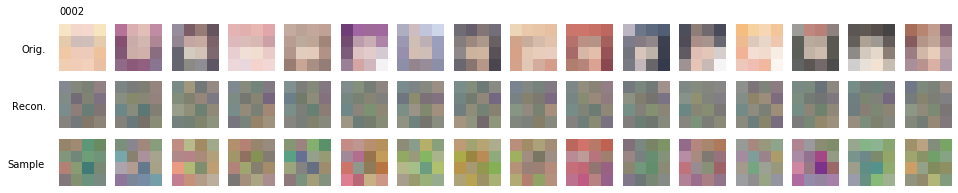

In [49]:
visualise_progress(z_test, test_batch, 2, save=False)

# Losses

In [50]:
def l2(x_true, x_pred):
    """
    L2 for the reciprocal loss in latent space
    
    :param - x_true - groundtruth
    :param - x_pred - prediction
    """
    return K.mean((x_true - x_pred)**2)

def discriminator_logistic_non_saturating(d_real, d_fake): 
    """
    Discriminator loss, where f = softplus.
    
    :param - d_real - discriminator real output
    :param - d_fake - discriminator real output
    """
    loss = f(-d_real) + f(d_fake)
  
    return K.mean(loss)


def generator_logistic_non_saturating(g_result):
    """
    generator loss, where f = softplus
    """
    loss = f(-g_result)
    return K.mean(loss)

# Optimizers

In [51]:
# Parameters
θ_F = F.trainable_weights
θ_G = G.trainable_weights
θ_E = E.trainable_weights
θ_D = D.trainable_weights

# Hyper-parameters
α = 0.001
β1 = 0.0
β2 = 0.99
ε = K.epsilon()
γ=0.1

# Optimizers
Adam_D = Adam(α, β1, β2, ε)
Adam_G = Adam(α, β1, β2, ε)
Adam_R = Adam(α, β1, β2, ε)

# Training

In [ ]:
epochs = 23 # 23 epochs = 500,000 training samples
BATCH_SIZE = 16 # 16 during merge

# Update data generator
data_gen.img_dim = DIM
data_gen.batch_size = BATCH_SIZE
test_batch = data_gen[0]

steps_per_epoch = data_gen.n // data_gen.batch_size

# Alphas for transition
step_size = 1/(steps_per_epoch*epochs)
alphas = np.arange(0, 1+step_size, step_size)
step = 1
merge = False


losses = {  "Loss_D" : [],
            "Loss_G" : [],
            "Loss_R" : [],
         }


# START
for epoch in range(0, epochs):
    
    print("Epoch:", epoch+1)
    
    # Create progress bar for current epoch
    progress = Progbar(steps_per_epoch, width=30, verbose=1, interval=1)

    for i in range(steps_per_epoch):
        
        if merge:
            # Set WeigtedSum Alphas
            K.set_value(G.get_layer("Weight_Sum_G").alpha, alphas[step])
            K.set_value(E.get_layer("Weight_Sum_E").alpha, alphas[step])
            step += 1
        

        # -------------------------------#
        # Step I - Update Discriminator  #
        # -------------------------------#
        
        # Random mini-batch from dataset
        batch = data_gen[i]
        
        x_real = batch[0]
        noise = batch[1]
        constant = batch[2]

        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # generate fake images
        x_fake = generator.predict([z, noise, constant])

        # Compute loss and apply gradients
        with tf.GradientTape() as tape:
            
            fake_pred = discriminator(x_fake)
            
            real_pred = discriminator(x_real)
            
            loss_d = discriminator_logistic_non_saturating(real_pred, fake_pred)
        
            #Add the R1 term
            if γ > 0:
                x_real = tf.Variable(x_real, dtype=tf.float32)
                with tf.GradientTape() as r1_tape:
                    r1_tape.watch(x_real)
                    # 1. Get the discriminator output for real images
                    pred = discriminator(x_real)

                # 2. Calculate the gradients w.r.t to the real images.
                grads = r1_tape.gradient(pred, [x_real])[0]

                # 3. Calcuate the squared norm of the gradients
                r1_penalty = K.sum(K.square(grads))
                loss_d += γ/2 * r1_penalty
            
            
        gradients = tape.gradient(loss_d, θ_E+θ_D)
        Adam_D.apply_gradients(zip(gradients, θ_E+θ_D))
        
        # ----------------------------#
        #  Step II - Update Generator #
        # ----------------------------#
        
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # Compute loss and apply gradients
        with tf.GradientTape() as tape:

            fake_pred = discriminator(generator([z, noise, constant]))

            loss_g = generator_logistic_non_saturating(fake_pred)

        gradients = tape.gradient(loss_g, θ_F+θ_G)
        Adam_G.apply_gradients(zip(gradients, θ_F+θ_G))
        
        # ------------------------------#
        #  Step III - Update Reciprocal #
        # ------------------------------#
        
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # Get w
        w = F(z)
        # Compute loss and apply gradients
        with tf.GradientTape() as tape:
            
            w_pred = reciprocal([w, noise, constant])
            
            loss_r = l2(w, w_pred)
            
        gradients = tape.gradient(loss_r, θ_G+θ_E)
        Adam_R.apply_gradients(zip(gradients, θ_G+θ_E))
        
        
        if i % 10 == 9:
            
            loss_d = loss_d.numpy()
            loss_g = loss_g.numpy()
            loss_r = loss_r.numpy()
            
            # Progress
            progress.update(i, values=[ ("Loss_D", loss_d),
                                        ("Loss_G", loss_g),
                                        ("Loss_R", loss_r),
                                        ("R1", r1_penalty.numpy())
                                      ])

            # Save losses each step
            losses["Loss_D"].append(loss_d)
            losses["Loss_G"].append(loss_g)
            losses["Loss_R"].append(loss_r)
    
    # ---------------#
    #  END OF EPOCH  #
    # ---------------#
    
    # LOSSES
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(range(len(losses["Loss_D"])), losses["Loss_D"], label="Discriminator")
    ax[0].plot(range(len(losses["Loss_G"])), losses["Loss_G"], label="Generator")
    ax[0].set_xlabel("Training Steps In Epoch")
    ax[0].set_ylabel("Adversarial Loss")
    ax[0].legend()

    ax[1].plot(range(len(losses["Loss_R"])), losses["Loss_R"])
    ax[1].set_xlabel("Training Steps In Epoch")
    ax[1].set_ylabel("Reciprocity Loss")
    plt.show()
    
    # IMAGES
    visualise_progress(z_test, test_batch, epoch, save=True)
    
    print("---------------------------------------------------------")
    
    
# Save weights and losses
G.save_weights(f"./weights/StyleWeights/G_{DIM}x{DIM}_weights.h5")
E.save_weights(f"./weights/StyleWeights/E_{DIM}x{DIM}_weights.h5")
F.save_weights(f"./weights/StyleWeights/F_{DIM}x{DIM}_weights.h5")
D.save_weights(f"./weights/StyleWeights/D_{DIM}x{DIM}_weights.h5")

pickle_out = open(f"./losses/losses_{DIM}x{DIM}.pickle","wb")
pickle.dump(losses, pickle_out)
pickle_out.close()

Epoch: 1
 379/1346 [=======>......................] - ETA: 3:30 - Loss_D: 1.4320 - Loss_G: 0.7239 - Loss_R: 0.4678 - R1: 1.4279